In [1]:
import os
import subprocess
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

In [2]:
import inspect
if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = inspect.getfullargspec
import voxelmorph as vxm
import neurite as ne

In [3]:
# voxelmorph_script = "voxelmorph/scripts/tf/voxelmorph3d.py"
voxelmorph_script = "voxelmorph/scripts/tf/train.py"
gpu_id = "0"

# Specify the image list files and the output directories for the models
training_data = [
    {"img_list": "t1_t2_image_list2.txt", "model_dir": "models/output_t1_t2"},
    #{"img_list": "t1_fa_image_list.txt", "model_dir": "models/output_t1_fa"},
    #{"img_list": "t1_adc_image_list.txt", "model_dir": "models/output_t1_adc"},
]

for data in training_data:
    img_list = data["img_list"]
    model_dir = data["model_dir"]

    # Ensure the model directory exists
    os.makedirs(model_dir, exist_ok=True)

    # Train the VoxelMorph model
    train_command = [
        "python",
        voxelmorph_script,
        "--img-list", img_list,
        "--model-dir", model_dir,
        "--gpu", gpu_id,
        "--epochs", "6000",
        "--steps-per-epoch", "100",
        "--batch-size", "1",
        "--lr", "1e-4",
    ]
    subprocess.run(train_command)

In [27]:
# initial shape (182, 218, 182)
vol_shape = (192, 224, 192)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

In [33]:
import nibabel as nib

img = nib.load("data/input/001/001/T1w_1mm.nii.gz")
print(img.shape)
print(img.header.get_zooms())
data = img.get_fdata()
data = np.pad(data, [(5, 5), (3, 3), (5, 5)], mode="constant")
print(data.shape)

img2 = nib.load("data/input/001/001/ADC_deformed.nii.gz")
print(img2.shape)
print(img2.header.get_zooms())

img3 = nib.load("data/input/001/001/FA_deformed.nii.gz")
print(img3.shape)
data3 = img3.get_fdata()
data3 = np.pad(data3, [(5, 5), (3, 3), (5, 5)], mode="constant")

img4 = nib.load("data/input/001/001/T2w_1mm_noalign.nii.gz")
print(img4.shape)
data4 = img4.get_fdata()
data4 = np.pad(data4, [(5, 5), (3, 3), (5, 5)], mode="constant")

x_train = np.stack((data, data4))
print(x_train.shape)

(182, 218, 182)
(1.0, 1.0, 1.0)
(192, 224, 192)
(145, 174, 145)
(1.25, 1.25, 1.25)
(145, 174, 145)
(182, 218, 182)
(2, 192, 224, 192)


In [28]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

In [34]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

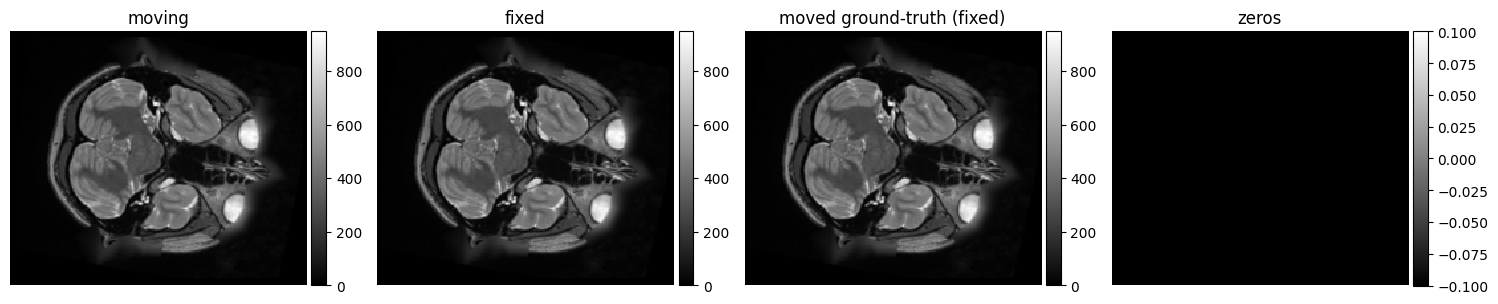

In [38]:
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 40] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [39]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2)

C:\Users\keert\AppData\Local\Temp\ipykernel_19224\1533479642.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);


Epoch 1/5
